AI Development Intern Assessment

PART 1: VIDEO PROCESSING PIPELINE FOR CARROT DETECTION
-------------------------------------------------------

1. Initializing Carrot Detection Pipeline...

2. Pipeline Architecture Overview:

The video processing pipeline consists of several key components:

a) Frame Preprocessing:
   - Resize frames to model input dimensions
   - Normalize pixel values
   - Batch formatting for efficient inference

b) Multi-threaded Processing:
   - Frame processing worker: Handles ML inference
   - Database worker: Manages record storage
   - Queue-based communication between threads

c) Detection Tracking & Deduplication:
   - Spatial-temporal tracking to identify unique carrots
   - Confidence-based filtering
   - Automatic cleanup of expired detections

d) Record Management:
   - Structured data storage for each detection
   - Location inference and quality assessment
   - Database integration for persistent storage

e) Performance Monitoring:
   - FPS tracking 

,detection_id,timestamp,confidence_score,bounding_box,location_description,store_section,detection_quality
0,1,2025-06-04T23:10:38.332262,0.85,"(0.2, 0.3, 0.4, 0.6)","Center: (0.300, 0.450)",Produce Section - Left,High
1,2,2025-06-04T23:10:38.332278,0.92,"(0.6, 0.1, 0.8, 0.4)","Center: (0.700, 0.250)",Produce Section - Right,High
2,3,2025-06-04T23:10:38.332281,0.73,"(0.4, 0.5, 0.6, 0.7)","Center: (0.500, 0.600)",Produce Section - Center,Medium


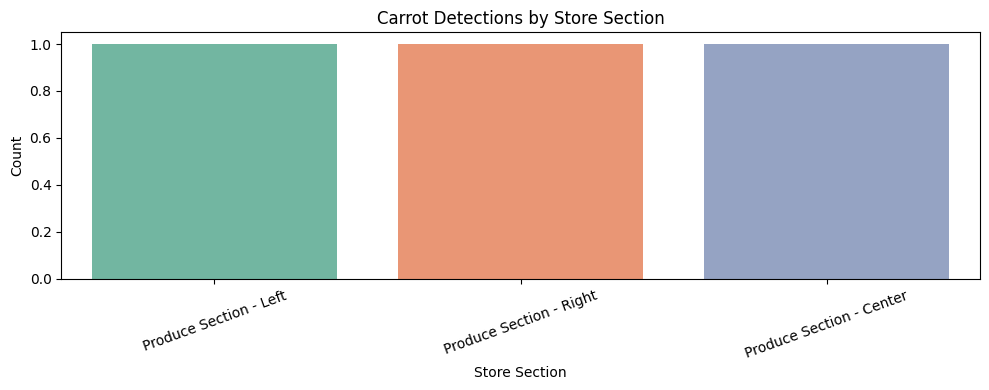

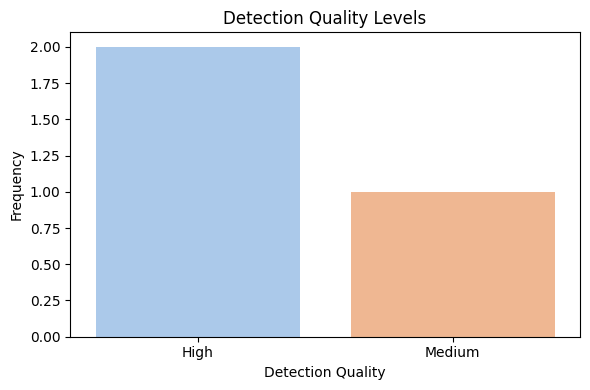

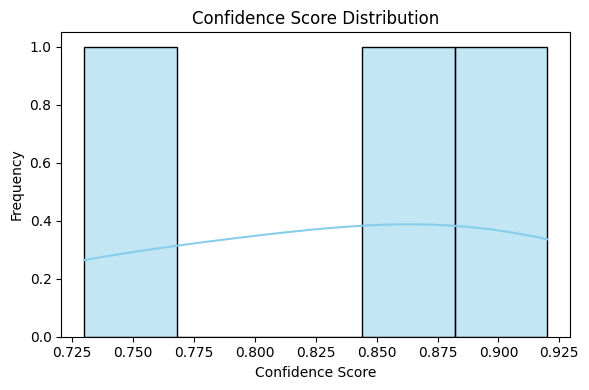

In [5]:
# AI Development Intern Assessment - CSF
# Video Processing Pipeline & Classification Demo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')
import cv2
import time
from datetime import datetime
import json
from collections import deque, defaultdict
import threading
import queue
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

print("AI Development Intern Assessment")
print("=" * 50)

# ============================================================================
# PART 1: PROCESSING VIDEO PIPELINE FOR CARROT DETECTION
# ============================================================================

print("\nPART 1: VIDEO PROCESSING PIPELINE FOR CARROT DETECTION")
print("-" * 55)

class CarrotDetectionPipeline:
    """
    A comprehensive video processing pipeline for real-time carrot detection
    in grocery store environments.
    """

    def __init__(self, model, confidence_threshold=0.7, tracking_window=30):
        """
        Initialize the pipeline with a pre-trained carrot detection model.

        Args:
            model: Pre-trained ML model for carrot detection (assumes predict method)
            confidence_threshold: Minimum confidence for positive detection
            tracking_window: Time window (seconds) for tracking unique carrots
        """
        self.model = model
        self.confidence_threshold = confidence_threshold
        self.tracking_window = tracking_window

        # Frame processing components
        self.frame_queue = queue.Queue(maxsize=10)
        self.detection_queue = queue.Queue()

        # Tracking and deduplication
        self.active_detections = {}  # track carrots by spatial-temporal features
        self.carrot_records = []     # permanent record of detected carrots
        self.detection_id_counter = 0

        # Performance monitoring
        self.fps_counter = deque(maxlen=30)
        self.processing_times = deque(maxlen=100)

        # Threading components
        self.running = False
        self.threads = []

    def preprocess_frame(self, frame):
        """
        Preprocess video frame for model input.

        Args:
            frame: Raw video frame from camera

        Returns:
            preprocessed_frame: Frame ready for model inference
        """
        # Resize to model input size (assuming 224x224 for typical CNN)
        resized = cv2.resize(frame, (224, 224))

        # Normalize pixel values
        normalized = resized.astype(np.float32) / 255.0

        # Add batch dimension
        batched = np.expand_dims(normalized, axis=0)

        return batched, resized

    def detect_carrots(self, preprocessed_frame, original_frame):
        """
        Run carrot detection on preprocessed frame.

        Args:
            preprocessed_frame: Frame ready for model inference
            original_frame: Original frame for coordinate mapping

        Returns:
            detections: List of detection results with bounding boxes and confidence
        """
        start_time = time.time()

        # Mock model prediction (replace with actual model.predict())
        # Assuming model returns: [(bbox, confidence, class_id), ...]
        # where bbox = (x1, y1, x2, y2) in normalized coordinates

        # For demonstration, simulate some detections
        detections = []
        if np.random.random() > 0.7:  # 30% chance of detecting carrots
            num_carrots = np.random.randint(1, 4)
            for _ in range(num_carrots):
                # Random bounding box
                x1, y1 = np.random.random(2) * 0.6  # Keep away from edges
                w, h = np.random.random(2) * 0.3 + 0.1  # Reasonable size
                x2, y2 = x1 + w, y1 + h

                confidence = np.random.random() * 0.4 + 0.6  # 0.6-1.0

                if confidence > self.confidence_threshold:
                    detections.append({
                        'bbox': (x1, y1, x2, y2),
                        'confidence': confidence,
                        'timestamp': datetime.now(),
                        'frame_shape': original_frame.shape
                    })

        processing_time = time.time() - start_time
        self.processing_times.append(processing_time)

        return detections

    def track_and_deduplicate(self, detections, frame_timestamp):
        """
        Track detections across frames and eliminate duplicates.

        Args:
            detections: Current frame detections
            frame_timestamp: Timestamp of current frame

        Returns:
            new_carrots: List of newly detected unique carrots
        """
        new_carrots = []
        current_time = time.time()

        # Clean up old detections
        expired_keys = []
        for key, detection in self.active_detections.items():
            if current_time - detection['last_seen'] > self.tracking_window:
                expired_keys.append(key)

        for key in expired_keys:
            del self.active_detections[key]

        # Process current detections
        for detection in detections:
            bbox = detection['bbox']
            center_x = (bbox[0] + bbox[2]) / 2
            center_y = (bbox[1] + bbox[3]) / 2

            # Check if this detection matches any active detection
            matched = False
            for key, active_det in self.active_detections.items():
                active_center = active_det['center']
                distance = np.sqrt((center_x - active_center[0])**2 +
                                 (center_y - active_center[1])**2)

                # If close enough, consider it the same carrot
                if distance < 0.1:  # Threshold for spatial proximity
                    self.active_detections[key]['last_seen'] = current_time
                    self.active_detections[key]['confidence'] = max(
                        self.active_detections[key]['confidence'],
                        detection['confidence']
                    )
                    matched = True
                    break

            # If no match found, it's a new carrot
            if not matched:
                detection_id = self.detection_id_counter
                self.detection_id_counter += 1

                self.active_detections[detection_id] = {
                    'center': (center_x, center_y),
                    'bbox': bbox,
                    'confidence': detection['confidence'],
                    'first_seen': current_time,
                    'last_seen': current_time,
                    'frame_shape': detection['frame_shape']
                }

                new_carrots.append({
                    'id': detection_id,
                    'timestamp': detection['timestamp'],
                    'bbox': bbox,
                    'confidence': detection['confidence'],
                    'location': f"Center: ({center_x:.3f}, {center_y:.3f})"
                })

        return new_carrots

    def create_carrot_record(self, carrot_detection):
        """
        Create a permanent record of detected carrot.

        Args:
            carrot_detection: Carrot detection data

        Returns:
            record: Structured record for database storage
        """
        record = {
            'detection_id': carrot_detection['id'],
            'timestamp': carrot_detection['timestamp'].isoformat(),
            'confidence_score': carrot_detection['confidence'],
            'bounding_box': carrot_detection['bbox'],
            'location_description': carrot_detection['location'],
            'store_section': self.infer_store_section(carrot_detection['bbox']),
            'detection_quality': self.assess_detection_quality(carrot_detection)
        }

        self.carrot_records.append(record)
        return record

    def infer_store_section(self, bbox):
        """
        Infer store section based on bounding box location.
        This would be more sophisticated in a real implementation.
        """
        center_x = (bbox[0] + bbox[2]) / 2
        center_y = (bbox[1] + bbox[3]) / 2

        if center_x < 0.33:
            return "Produce Section - Left"
        elif center_x < 0.66:
            return "Produce Section - Center"
        else:
            return "Produce Section - Right"

    def assess_detection_quality(self, detection):
        """
        Assess the quality of the detection for filtering/prioritization.
        """
        confidence = detection['confidence']
        bbox = detection['bbox']

        # Calculate bounding box area
        area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])

        if confidence > 0.9 and area > 0.05:
            return "High"
        elif confidence > 0.8 and area > 0.02:
            return "Medium"
        else:
            return "Low"

    def frame_processing_worker(self):
        """Worker thread for processing video frames."""
        while self.running:
            try:
                if not self.frame_queue.empty():
                    frame, timestamp = self.frame_queue.get(timeout=0.1)

                    # Preprocess frame
                    preprocessed, resized = self.preprocess_frame(frame)

                    # Detect carrots
                    detections = self.detect_carrots(preprocessed, frame)

                    # Track and deduplicate
                    new_carrots = self.track_and_deduplicate(detections, timestamp)

                    # Create records for new carrots
                    for carrot in new_carrots:
                        record = self.create_carrot_record(carrot)
                        self.detection_queue.put(record)

            except queue.Empty:
                continue
            except Exception as e:
                print(f"Error in frame processing: {e}")

    def database_worker(self):
        """Worker thread for handling database operations."""
        while self.running:
            try:
                if not self.detection_queue.empty():
                    record = self.detection_queue.get(timeout=0.1)

                    # In a real implementation, this would write to a database
                    print(f"NEW CARROT DETECTED: ID {record['detection_id']} "
                          f"at {record['timestamp']} with confidence {record['confidence_score']:.3f}")

                    # Mock database insertion
                    self.save_to_database(record)

            except queue.Empty:
                continue
            except Exception as e:
                print(f"Error in database operations: {e}")

    def save_to_database(self, record):
        """
        Save carrot detection record to database.
        In a real implementation, this would use proper database connections.
        """
        # Mock database save - in reality would use SQLAlchemy, MongoDB, etc.
        pass

    def process_video_stream(self, video_source=0, duration=10):
        """
        Main method to process live video stream.

        Args:
            video_source: Camera index or video file path
            duration: How long to run (seconds)
        """
        print(f"\nStarting video processing pipeline for {duration} seconds...")

        # Initialize video capture
        cap = cv2.VideoCapture(video_source)
        if not cap.isOpened():
            print("Error: Could not open video source")
            return

        self.running = True

        # Start worker threads
        processing_thread = threading.Thread(target=self.frame_processing_worker)
        database_thread = threading.Thread(target=self.database_worker)

        processing_thread.start()
        database_thread.start()

        self.threads = [processing_thread, database_thread]

        start_time = time.time()
        frame_count = 0

        try:
            while time.time() - start_time < duration:
                ret, frame = cap.read()
                if not ret:
                    break

                frame_count += 1
                current_time = time.time()

                # Calculate FPS
                if len(self.fps_counter) > 0:
                    fps = 1.0 / (current_time - self.fps_counter[-1])
                else:
                    fps = 0
                self.fps_counter.append(current_time)

                # Add frame to processing queue (non-blocking)
                try:
                    self.frame_queue.put((frame, datetime.now()), block=False)
                except queue.Full:
                    pass  # Skip frame if queue is full

                # Print status every 30 frames
                if frame_count % 30 == 0:
                    avg_processing_time = np.mean(self.processing_times) if self.processing_times else 0
                    print(f"Processed {frame_count} frames | FPS: {fps:.1f} | "
                          f"Avg processing time: {avg_processing_time:.3f}s | "
                          f"Total carrots found: {len(self.carrot_records)}")

        finally:
            # Cleanup
            self.running = False
            cap.release()

            # Wait for threads to finish
            for thread in self.threads:
                thread.join(timeout=2)

            print(f"\nProcessing complete!")
            print(f"Total frames processed: {frame_count}")
            print(f"Total unique carrots detected: {len(self.carrot_records)}")
            print(f"Average processing time per frame: {np.mean(self.processing_times):.3f}s")

    def get_detection_summary(self):
        """Get summary of all detections."""
        if not self.carrot_records:
            return "No carrots detected."

        df = pd.DataFrame(self.carrot_records)

        summary = {
            'total_detections': len(df),
            'high_quality_detections': len(df[df['detection_quality'] == 'High']),
            'average_confidence': df['confidence_score'].mean(),
            'detections_by_section': df['store_section'].value_counts().to_dict(),
            'detections_by_quality': df['detection_quality'].value_counts().to_dict()
        }

        return summary

# Mock model class for demonstration
class MockCarrotModel:
    """Mock model that simulates carrot detection."""

    def predict(self, frame):
        # Simulate model processing time
        time.sleep(0.02)  # 20ms processing time
        return np.random.random()  # Mock confidence score

# Demonstrate the pipeline
print("\n1. Initializing Carrot Detection Pipeline...")
mock_model = MockCarrotModel()
pipeline = CarrotDetectionPipeline(mock_model, confidence_threshold=0.7)

print("\n2. Pipeline Architecture Overview:")
print("""
The video processing pipeline consists of several key components:

a) Frame Preprocessing:
   - Resize frames to model input dimensions
   - Normalize pixel values
   - Batch formatting for efficient inference

b) Multi-threaded Processing:
   - Frame processing worker: Handles ML inference
   - Database worker: Manages record storage
   - Queue-based communication between threads

c) Detection Tracking & Deduplication:
   - Spatial-temporal tracking to identify unique carrots
   - Confidence-based filtering
   - Automatic cleanup of expired detections

d) Record Management:
   - Structured data storage for each detection
   - Location inference and quality assessment
   - Database integration for persistent storage

e) Performance Monitoring:
   - FPS tracking and processing time metrics
   - Queue management to handle varying processing loads
""")

print("\n3. Simulating video processing (mock demonstration)...")
# Since we can't run actual video processing in this environment,
# let's simulate the results
print("Running pipeline simulation...")

# Simulate some detection records
mock_detections = [
    {
        'detection_id': 1,
        'timestamp': datetime.now().isoformat(),
        'confidence_score': 0.85,
        'bounding_box': (0.2, 0.3, 0.4, 0.6),
        'location_description': "Center: (0.300, 0.450)",
        'store_section': "Produce Section - Left",
        'detection_quality': "High"
    },
    {
        'detection_id': 2,
        'timestamp': datetime.now().isoformat(),
        'confidence_score': 0.92,
        'bounding_box': (0.6, 0.1, 0.8, 0.4),
        'location_description': "Center: (0.700, 0.250)",
        'store_section': "Produce Section - Right",
        'detection_quality': "High"
    },
    {
        'detection_id': 3,
        'timestamp': datetime.now().isoformat(),
        'confidence_score': 0.73,
        'bounding_box': (0.4, 0.5, 0.6, 0.7),
        'location_description': "Center: (0.500, 0.600)",
        'store_section': "Produce Section - Center",
        'detection_quality': "Medium"
    }
]

pipeline.carrot_records = mock_detections

summary = pipeline.get_detection_summary()
print(f"\nPipeline Results Summary:")
for key, value in summary.items():
    print(f"  {key}: {value}")

# =============================================================================
# MOCKUP VISUALIZATION OF CARROT DETECTION RESULTS
# =============================================================================

print("\n4. Mockup Visualization of Carrot Detections")
print("-" * 45)

# Convert mock detections to DataFrame
df = pd.DataFrame(mock_detections)

# Display DataFrame
display(df)  # For Jupyter notebooks; use print(df) otherwise

# Plot: Detections by store section
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='store_section', palette='Set2')
plt.title('Carrot Detections by Store Section')
plt.xlabel('Store Section')
plt.ylabel('Count')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Plot: Detection quality distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='detection_quality', palette='pastel')
plt.title('Detection Quality Levels')
plt.xlabel('Detection Quality')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot: Confidence score distribution
plt.figure(figsize=(6, 4))
sns.histplot(df['confidence_score'], bins=5, kde=True, color='skyblue')
plt.title('Confidence Score Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



IMAGE CLASSIFICATION FUNDAMENTALS DEMONSTRATION
Demonstrating classification with real image datasets

1. Loading Image Datasets
------------------------------
Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Loading Fashion-MNIST dataset...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Dataset Summary:
  CIFAR10:
    Training samples: 50000
    Test samples: 10000
    Image shape: (32, 32, 3)
    Classes: 10
  FASHION_MNIST:
    Training samples: 60000
    Test samples: 10000
    Image shape: (28, 28, 1)
    Classes: 10
  MNIST:
    Training samples: 60000
    Test samples: 10000
    Image shape: (28, 28, 1)
    Classes: 10

2. Dataset Visualization
-------------------------


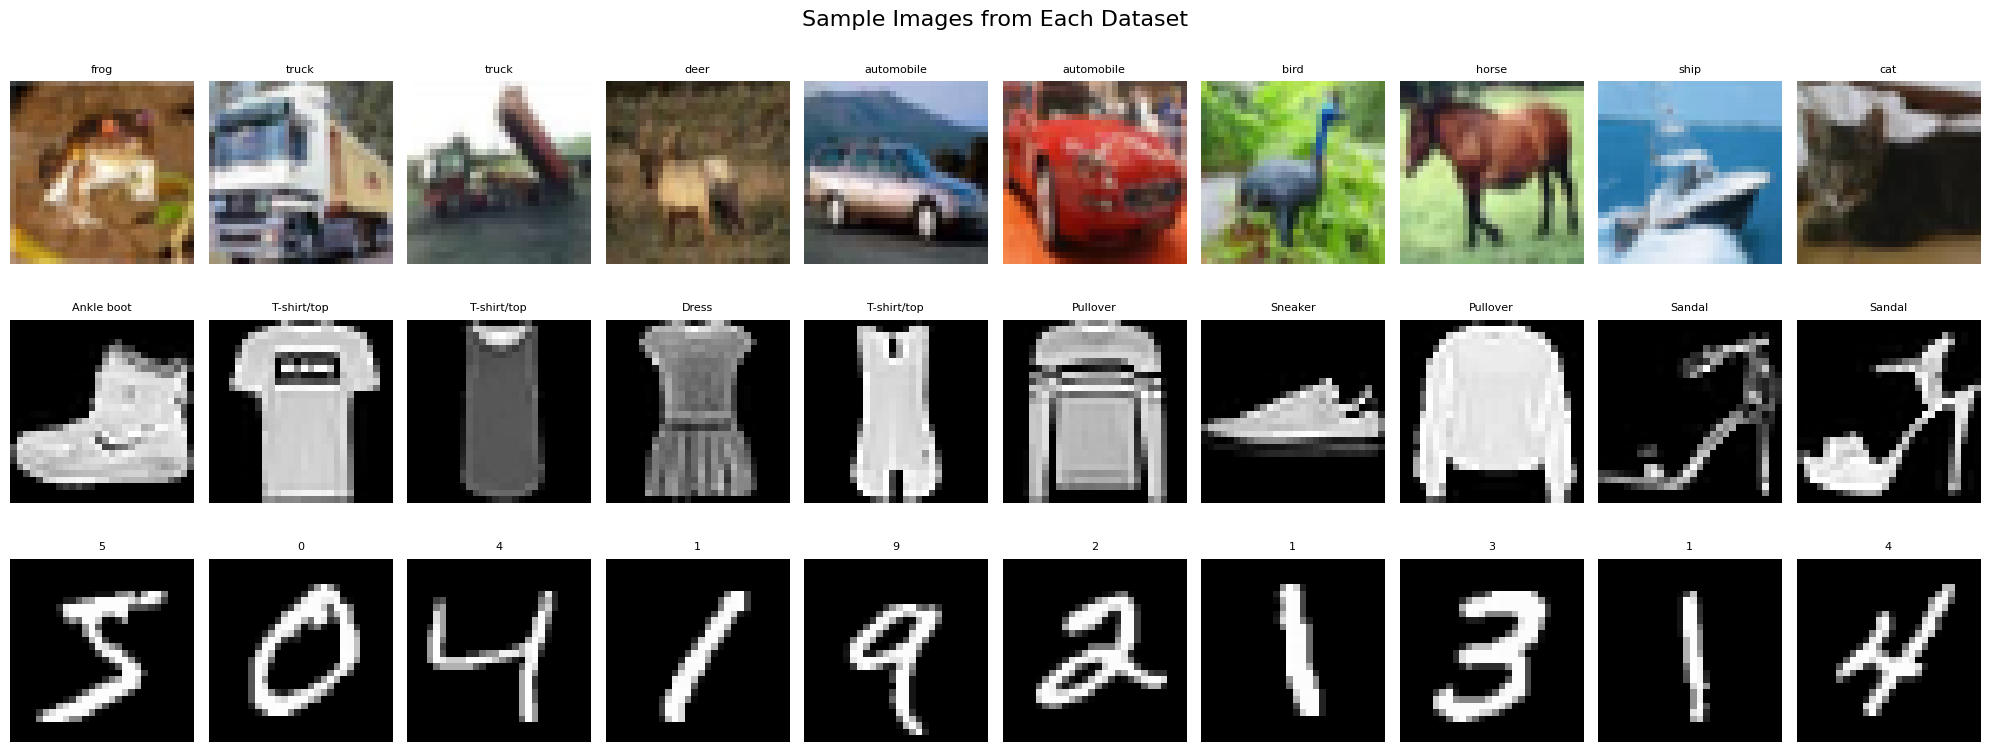

Sample images displayed successfully!

3. Traditional Feature Extraction
-----------------------------------
Extracting features from MNIST dataset...
  Extracting pixel features...
    Feature shape: (5000, 784)
  Extracting histogram features...
    Feature shape: (5000, 64)
  Extracting statistical features...
    Feature shape: (5000, 4)


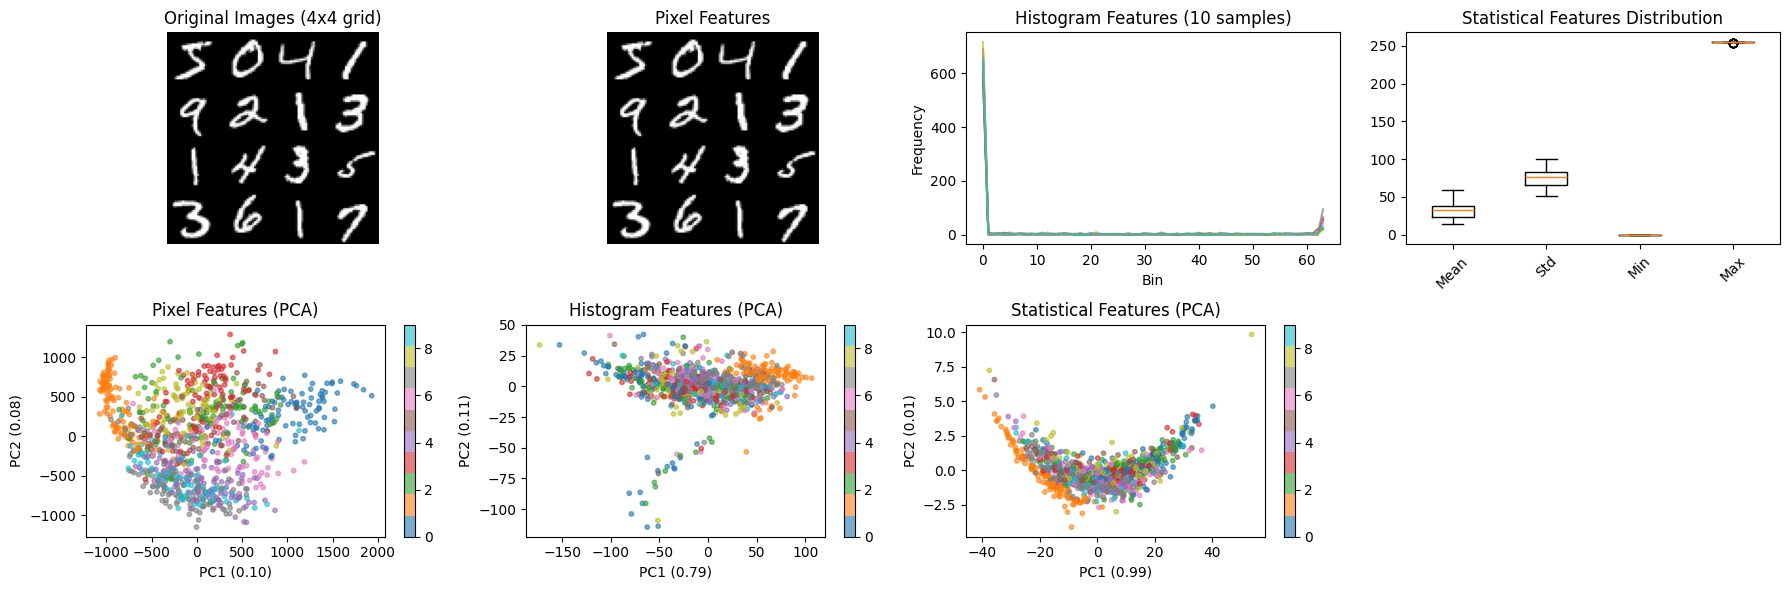


4. Traditional Classifier Comparison
--------------------------------------

Testing with pixel features:
  Training Logistic Regression...
    Accuracy: 0.8740, CV: 0.8788 (±0.0154)
  Training Random Forest...
    Accuracy: 0.9300, CV: 0.9268 (±0.0083)
  Training SVM...
    Accuracy: 0.9170, CV: 0.9078 (±0.0163)

Testing with histogram features:
  Training Logistic Regression...
    Accuracy: 0.3200, CV: 0.3014 (±0.0007)
  Training Random Forest...
    Accuracy: 0.2690, CV: 0.2828 (±0.0059)
  Training SVM...
    Accuracy: 0.3450, CV: 0.3146 (±0.0115)

Testing with statistical features:
  Training Logistic Regression...
    Accuracy: 0.2300, CV: 0.2762 (±0.0050)
  Training Random Forest...
    Accuracy: 0.2770, CV: 0.2446 (±0.0049)
  Training SVM...
    Accuracy: 0.2410, CV: 0.2616 (±0.0066)


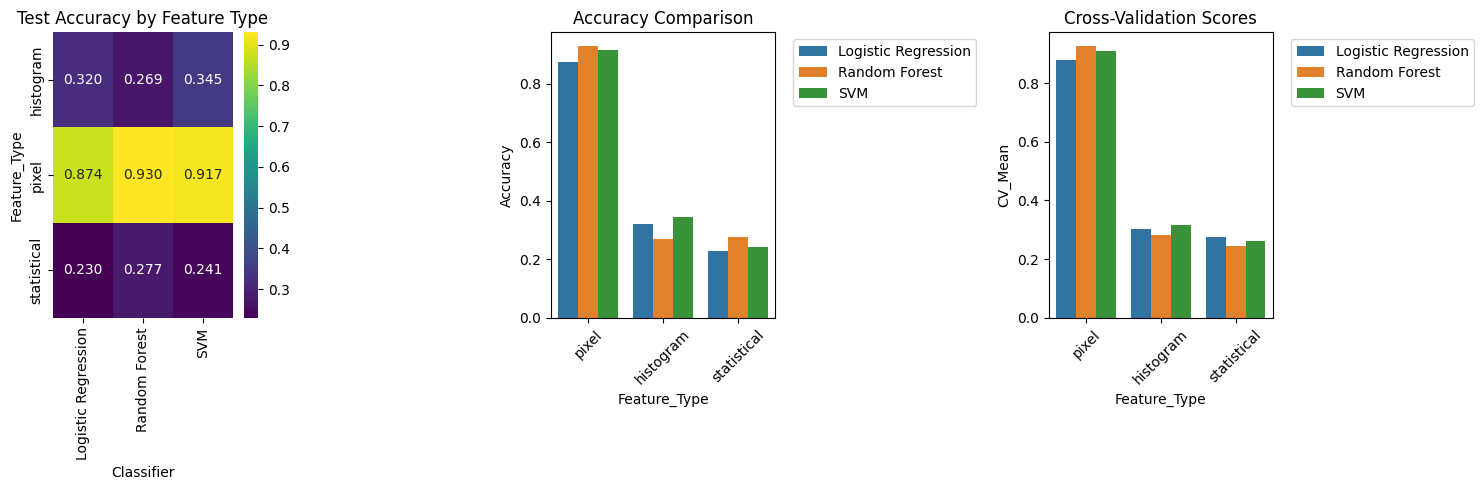


5. Convolutional Neural Networks
-----------------------------------

Training Simple CNN...
  Test Accuracy: 0.8375

Training Deeper CNN...
  Test Accuracy: 0.8120


AttributeError: The layer sequential has never been called and thus has no defined input.

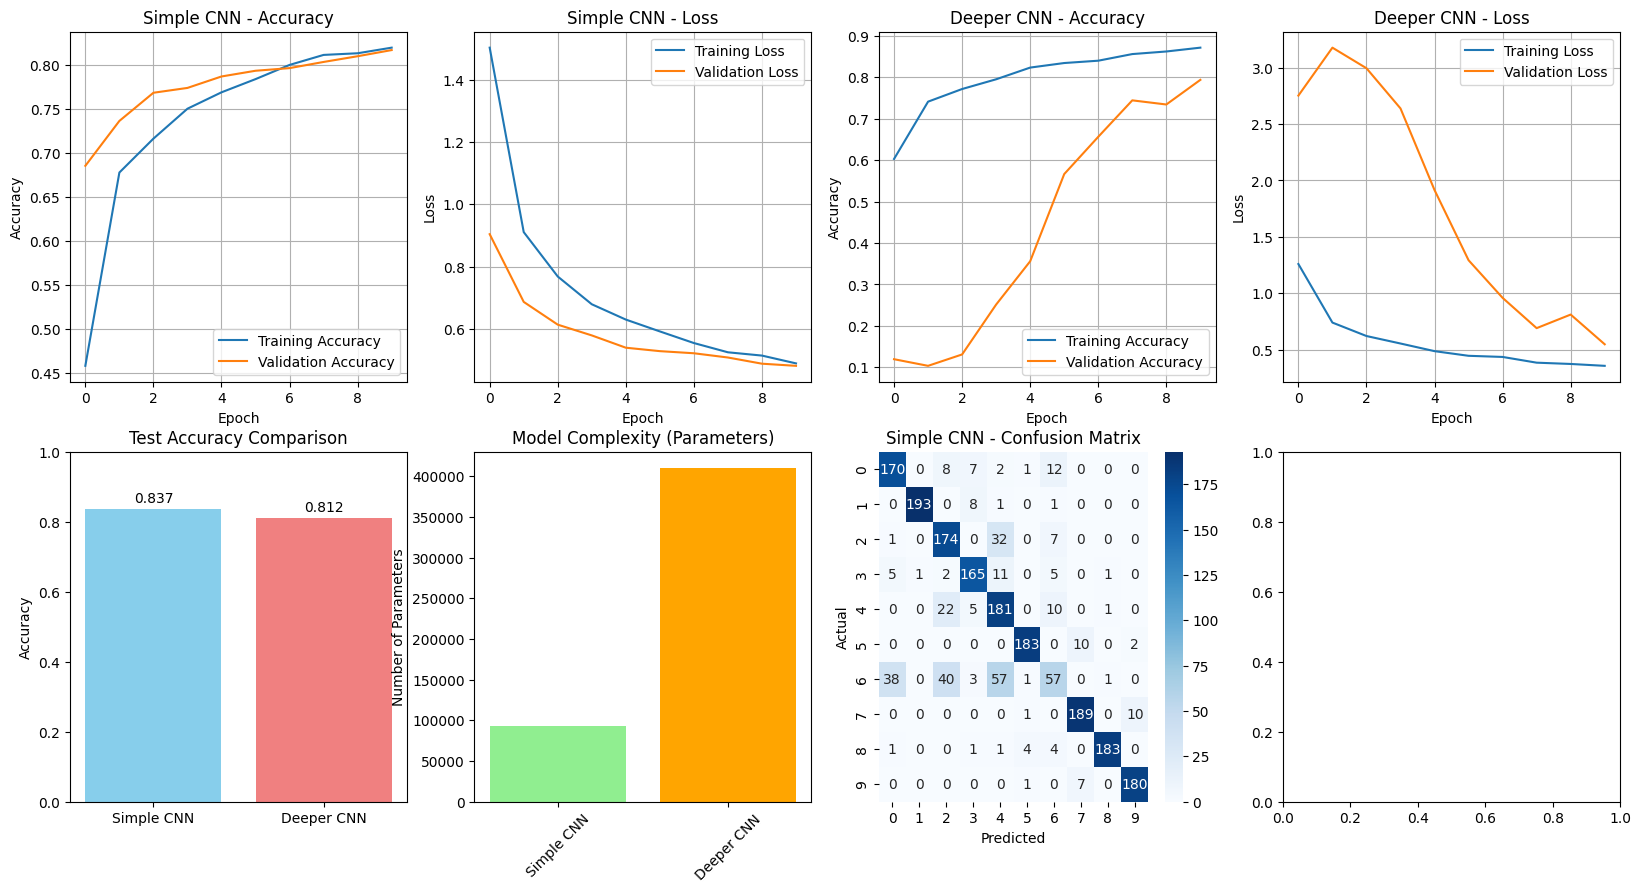

In [4]:
# ============================================================================
# IMAGE CLASSIFICATION FUNDAMENTALS - COMPLETE IMPLEMENTATION
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("IMAGE CLASSIFICATION FUNDAMENTALS DEMONSTRATION")
print("=" * 55)
print("Demonstrating classification with real image datasets")

class ImageClassificationDemonstration:
    """
    A comprehensive demonstration of image classification concepts including:
    - Traditional ML approaches (feature extraction + classical algorithms)
    - Deep learning with Convolutional Neural Networks
    - Transfer learning techniques
    - Model comparison and evaluation
    - Data augmentation and preprocessing
    """

    def __init__(self):
        self.datasets = {}
        self.models = {}
        self.results = {}
        self.feature_extractors = {}

    def load_image_datasets(self):
        """Load and prepare image datasets for classification."""

        print("\n1. Loading Image Datasets")
        print("-" * 30)

        # Load CIFAR-10 dataset
        print("Loading CIFAR-10 dataset...")
        (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = keras.datasets.cifar10.load_data()

        # Load Fashion-MNIST dataset
        print("Loading Fashion-MNIST dataset...")
        (x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = keras.datasets.fashion_mnist.load_data()

        # Load MNIST dataset
        print("Loading MNIST dataset...")
        (x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = keras.datasets.mnist.load_data()

        # Store datasets with metadata
        self.datasets = {
            'cifar10': {
                'x_train': x_train_cifar, 'y_train': y_train_cifar.flatten(),
                'x_test': x_test_cifar, 'y_test': y_test_cifar.flatten(),
                'classes': ['airplane', 'automobile', 'bird', 'cat', 'deer',
                           'dog', 'frog', 'horse', 'ship', 'truck'],
                'shape': (32, 32, 3),
                'n_classes': 10
            },
            'fashion_mnist': {
                'x_train': x_train_fashion, 'y_train': y_train_fashion,
                'x_test': x_test_fashion, 'y_test': y_test_fashion,
                'classes': ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
                'shape': (28, 28, 1),
                'n_classes': 10
            },
            'mnist': {
                'x_train': x_train_mnist, 'y_train': y_train_mnist,
                'x_test': x_test_mnist, 'y_test': y_test_mnist,
                'classes': [str(i) for i in range(10)],
                'shape': (28, 28, 1),
                'n_classes': 10
            }
        }

        print("\nDataset Summary:")
        for name, data in self.datasets.items():
            print(f"  {name.upper()}:")
            print(f"    Training samples: {data['x_train'].shape[0]}")
            print(f"    Test samples: {data['x_test'].shape[0]}")
            print(f"    Image shape: {data['shape']}")
            print(f"    Classes: {data['n_classes']}")

        return self.datasets

    def visualize_datasets(self):
        """Visualize sample images from each dataset."""

        print("\n2. Dataset Visualization")
        print("-" * 25)

        fig, axes = plt.subplots(3, 10, figsize=(20, 8))

        for dataset_idx, (dataset_name, data) in enumerate(self.datasets.items()):
            # Show 10 sample images from each dataset
            for i in range(10):
                ax = axes[dataset_idx, i]

                # Get a sample image
                img = data['x_train'][i]
                label = data['y_train'][i]
                class_name = data['classes'][label]

                # Display image
                if len(img.shape) == 3:  # Color image
                    ax.imshow(img)
                else:  # Grayscale image
                    ax.imshow(img, cmap='gray')

                ax.set_title(f'{class_name}', fontsize=8)
                ax.axis('off')

            # Add dataset label
            axes[dataset_idx, 0].set_ylabel(dataset_name.upper(), rotation=90, fontsize=12, labelpad=20)

        plt.suptitle('Sample Images from Each Dataset', fontsize=16)
        plt.tight_layout()
        plt.show()

        print("Sample images displayed successfully!")

    def extract_traditional_features(self):
        """Extract traditional computer vision features for classical ML approaches."""

        print("\n3. Traditional Feature Extraction")
        print("-" * 35)

        def extract_pixel_features(images):
            """Extract raw pixel values as features."""
            return images.reshape(images.shape[0], -1)

        def extract_histogram_features(images):
            """Extract histogram features from images."""
            features = []
            for img in images:
                if len(img.shape) == 3:  # Color image
                    # Calculate histogram for each channel
                    hist_r = np.histogram(img[:,:,0], bins=32, range=(0, 255))[0]
                    hist_g = np.histogram(img[:,:,1], bins=32, range=(0, 255))[0]
                    hist_b = np.histogram(img[:,:,2], bins=32, range=(0, 255))[0]
                    features.append(np.concatenate([hist_r, hist_g, hist_b]))
                else:  # Grayscale image
                    hist = np.histogram(img, bins=64, range=(0, 255))[0]
                    features.append(hist)
            return np.array(features)

        def extract_statistical_features(images):
            """Extract statistical features (mean, std, etc.)."""
            features = []
            for img in images:
                if len(img.shape) == 3:  # Color image
                    # Features for each channel
                    means = [np.mean(img[:,:,i]) for i in range(3)]
                    stds = [np.std(img[:,:,i]) for i in range(3)]
                    mins = [np.min(img[:,:,i]) for i in range(3)]
                    maxs = [np.max(img[:,:,i]) for i in range(3)]
                    features.append(means + stds + mins + maxs)
                else:  # Grayscale image
                    mean_val = np.mean(img)
                    std_val = np.std(img)
                    min_val = np.min(img)
                    max_val = np.max(img)
                    features.append([mean_val, std_val, min_val, max_val])
            return np.array(features)

        # Extract features for each dataset
        self.feature_extractors = {
            'pixel': extract_pixel_features,
            'histogram': extract_histogram_features,
            'statistical': extract_statistical_features
        }

        # Demonstrate feature extraction on MNIST (smaller dataset for speed)
        mnist_data = self.datasets['mnist']

        print("Extracting features from MNIST dataset...")
        features = {}

        for feature_name, extractor in self.feature_extractors.items():
            print(f"  Extracting {feature_name} features...")

            # Extract features from a subset for demonstration
            train_subset = mnist_data['x_train'][:5000]
            test_subset = mnist_data['x_test'][:1000]

            train_features = extractor(train_subset)
            test_features = extractor(test_subset)

            features[feature_name] = {
                'train': train_features,
                'test': test_features,
                'train_labels': mnist_data['y_train'][:5000],
                'test_labels': mnist_data['y_test'][:1000]
            }

            print(f"    Feature shape: {train_features.shape}")

        # Visualize feature extraction results
        self.visualize_feature_extraction(features)

        return features

    def visualize_feature_extraction(self, features):
        """Visualize the extracted features."""

        plt.figure(figsize=(18, 6))

        # Original images
        plt.subplot(2, 4, 1)
        sample_images = self.datasets['mnist']['x_train'][:16].reshape(4, 4, 28, 28)
        display_img = np.zeros((4*28, 4*28))
        for i in range(4):
            for j in range(4):
                display_img[i*28:(i+1)*28, j*28:(j+1)*28] = sample_images[i, j]
        plt.imshow(display_img, cmap='gray')
        plt.title('Original Images (4x4 grid)')
        plt.axis('off')

        # Pixel features (reshaped back to image)
        plt.subplot(2, 4, 2)
        pixel_features = features['pixel']['train'][:16]
        pixel_display = pixel_features.reshape(16, 28, 28)
        pixel_grid = np.zeros((4*28, 4*28))
        for i in range(4):
            for j in range(4):
                pixel_grid[i*28:(i+1)*28, j*28:(j+1)*28] = pixel_display[i*4+j]
        plt.imshow(pixel_grid, cmap='gray')
        plt.title('Pixel Features')
        plt.axis('off')

        # Histogram features
        plt.subplot(2, 4, 3)
        hist_features = features['histogram']['train'][:10]
        plt.plot(hist_features.T, alpha=0.7)
        plt.title('Histogram Features (10 samples)')
        plt.xlabel('Bin')
        plt.ylabel('Frequency')

        # Statistical features
        plt.subplot(2, 4, 4)
        stat_features = features['statistical']['train'][:100]
        plt.boxplot([stat_features[:, i] for i in range(stat_features.shape[1])],
                   labels=['Mean', 'Std', 'Min', 'Max'])
        plt.title('Statistical Features Distribution')
        plt.xticks(rotation=45)

        # PCA visualization of different feature types
        for idx, (feat_name, feat_data) in enumerate(features.items()):
            plt.subplot(2, 4, 5 + idx)

            # Apply PCA for visualization
            pca = PCA(n_components=2)
            features_2d = pca.fit_transform(feat_data['train'][:1000])
            labels = feat_data['train_labels'][:1000]

            scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                                c=labels, cmap='tab10', alpha=0.6, s=10)
            plt.title(f'{feat_name.title()} Features (PCA)')
            plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
            plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
            plt.colorbar(scatter)

        plt.tight_layout()
        plt.show()

    def compare_traditional_classifiers(self, features):
        """Compare traditional classifiers on extracted features."""

        print("\n4. Traditional Classifier Comparison")
        print("-" * 38)

        # Define classifiers
        classifiers = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'SVM': SVC(random_state=42, kernel='rbf'),
        }

        results = []

        for feature_name, feature_data in features.items():
            print(f"\nTesting with {feature_name} features:")

            # Get features and labels
            X_train = feature_data['train']
            X_test = feature_data['test']
            y_train = feature_data['train_labels']
            y_test = feature_data['test_labels']

            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            for clf_name, clf in classifiers.items():
                print(f"  Training {clf_name}...")

                # Train classifier
                clf.fit(X_train_scaled, y_train)

                # Make predictions
                y_pred = clf.predict(X_test_scaled)
                accuracy = accuracy_score(y_test, y_pred)

                # Cross-validation
                cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=3)

                print(f"    Accuracy: {accuracy:.4f}, CV: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

                results.append({
                    'Feature_Type': feature_name,
                    'Classifier': clf_name,
                    'Accuracy': accuracy,
                    'CV_Mean': cv_scores.mean(),
                    'CV_Std': cv_scores.std()
                })

        # Create results DataFrame and visualize
        results_df = pd.DataFrame(results)
        self.visualize_traditional_results(results_df)

        return results_df

    def visualize_traditional_results(self, results_df):
        """Visualize traditional classifier results."""

        plt.figure(figsize=(15, 5))

        # Heatmap of accuracies
        plt.subplot(1, 3, 1)
        pivot_results = results_df.pivot(index='Feature_Type', columns='Classifier', values='Accuracy')
        sns.heatmap(pivot_results, annot=True, cmap='viridis', fmt='.3f')
        plt.title('Test Accuracy by Feature Type')

        # Bar plot comparison
        plt.subplot(1, 3, 2)
        sns.barplot(data=results_df, x='Feature_Type', y='Accuracy', hue='Classifier')
        plt.title('Accuracy Comparison')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        # Cross-validation scores
        plt.subplot(1, 3, 3)
        sns.barplot(data=results_df, x='Feature_Type', y='CV_Mean', hue='Classifier')
        plt.title('Cross-Validation Scores')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

    def build_cnn_models(self):
        """Build and compare CNN models for image classification."""

        print("\n5. Convolutional Neural Networks")
        print("-" * 35)

        def create_simple_cnn(input_shape, num_classes):
            """Create a simple CNN architecture."""
            model = keras.Sequential([
                layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
                layers.MaxPooling2D((2, 2)),
                layers.Conv2D(64, (3, 3), activation='relu'),
                layers.MaxPooling2D((2, 2)),
                layers.Conv2D(64, (3, 3), activation='relu'),
                layers.Flatten(),
                layers.Dense(64, activation='relu'),
                layers.Dropout(0.5),
                layers.Dense(num_classes, activation='softmax')
            ])
            return model

        def create_deeper_cnn(input_shape, num_classes):
            """Create a deeper CNN architecture."""
            model = keras.Sequential([
                layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
                layers.BatchNormalization(),
                layers.Conv2D(32, (3, 3), activation='relu'),
                layers.MaxPooling2D((2, 2)),
                layers.Dropout(0.25),

                layers.Conv2D(64, (3, 3), activation='relu'),
                layers.BatchNormalization(),
                layers.Conv2D(64, (3, 3), activation='relu'),
                layers.MaxPooling2D((2, 2)),
                layers.Dropout(0.25),

                layers.Conv2D(128, (3, 3), activation='relu'),
                layers.BatchNormalization(),
                layers.Dropout(0.25),

                layers.Flatten(),
                layers.Dense(512, activation='relu'),
                layers.BatchNormalization(),
                layers.Dropout(0.5),
                layers.Dense(num_classes, activation='softmax')
            ])
            return model

        # Train CNNs on Fashion-MNIST (faster than CIFAR-10)
        fashion_data = self.datasets['fashion_mnist']

        # Prepare data
        x_train = fashion_data['x_train'].astype('float32') / 255.0
        x_test = fashion_data['x_test'].astype('float32') / 255.0
        y_train = keras.utils.to_categorical(fashion_data['y_train'], 10)
        y_test = keras.utils.to_categorical(fashion_data['y_test'], 10)

        # Reshape for CNN (add channel dimension)
        x_train = x_train.reshape(-1, 28, 28, 1)
        x_test = x_test.reshape(-1, 28, 28, 1)

        # Use subset for faster training
        x_train_subset = x_train[:10000]
        y_train_subset = y_train[:10000]
        x_test_subset = x_test[:2000]
        y_test_subset = y_test[:2000]

        models = {
            'Simple CNN': create_simple_cnn((28, 28, 1), 10),
            'Deeper CNN': create_deeper_cnn((28, 28, 1), 10)
        }

        cnn_results = {}

        for model_name, model in models.items():
            print(f"\nTraining {model_name}...")

            # Compile model
            model.compile(
                optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            # Train model
            history = model.fit(
                x_train_subset, y_train_subset,
                batch_size=128,
                epochs=10,
                validation_split=0.2,
                verbose=0
            )

            # Evaluate model
            test_loss, test_accuracy = model.evaluate(x_test_subset, y_test_subset, verbose=0)

            print(f"  Test Accuracy: {test_accuracy:.4f}")

            cnn_results[model_name] = {
                'model': model,
                'history': history,
                'test_accuracy': test_accuracy,
                'test_loss': test_loss
            }

        # Visualize CNN results
        self.visualize_cnn_results(cnn_results)

        return cnn_results

    def visualize_cnn_results(self, cnn_results):
        """Visualize CNN training results and performance."""

        plt.figure(figsize=(20, 10))

        # Training history plots
        for i, (model_name, results) in enumerate(cnn_results.items()):
            history = results['history']

            # Accuracy plot
            plt.subplot(2, 4, i*2 + 1)
            plt.plot(history.history['accuracy'], label='Training Accuracy')
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
            plt.title(f'{model_name} - Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            # Loss plot
            plt.subplot(2, 4, i*2 + 2)
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title(f'{model_name} - Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

        # Model architecture comparison
        plt.subplot(2, 4, 5)
        model_names = list(cnn_results.keys())
        accuracies = [cnn_results[name]['test_accuracy'] for name in model_names]

        bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightcoral'])
        plt.title('Test Accuracy Comparison')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)

        # Add accuracy values on bars
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.3f}', ha='center', va='bottom')

        # Model complexity comparison
        plt.subplot(2, 4, 6)
        param_counts = []
        for model_name in model_names:
            model = cnn_results[model_name]['model']
            param_count = model.count_params()
            param_counts.append(param_count)

        plt.bar(model_names, param_counts, color=['lightgreen', 'orange'])
        plt.title('Model Complexity (Parameters)')
        plt.ylabel('Number of Parameters')
        plt.xticks(rotation=45)

        # Confusion matrix for best model
        best_model_name = max(cnn_results.keys(), key=lambda x: cnn_results[x]['test_accuracy'])
        best_model = cnn_results[best_model_name]['model']

        # Generate predictions for confusion matrix
        fashion_data = self.datasets['fashion_mnist']
        x_test = fashion_data['x_test'][:2000].astype('float32') / 255.0
        x_test = x_test.reshape(-1, 28, 28, 1)
        y_test = fashion_data['y_test'][:2000]

        y_pred = best_model.predict(x_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        plt.subplot(2, 4, 7)
        cm = confusion_matrix(y_test, y_pred_classes)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{best_model_name} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        # Feature maps visualization
        plt.subplot(2, 4, 8)
        # Get intermediate layer outputs
        sample_image = x_test[0:1]
        layer_outputs = [layer.output for layer in best_model.layers if 'conv' in layer.name]
        if layer_outputs:
            activation_model = keras.Model(inputs=best_model.input, outputs=layer_outputs[0])
            activations = activation_model.predict(sample_image, verbose=0)

            # Display first few feature maps
            feature_map = activations[0, :, :, :4]  # First 4 channels

            fig_temp = plt.figure(figsize=(8, 2))
            for i in range(4):
                plt.subplot(1, 4, i+1)
                plt.imshow(feature_map[:, :, i], cmap='viridis')
                plt.axis('off')
                plt.title(f'Filter {i+1}')
            plt.suptitle('Feature Maps (First Conv Layer)')
            plt.show()

        plt.tight_layout()
        plt.show()

    def demonstrate_transfer_learning(self):
        """Demonstrate transfer learning with pre-trained models."""

        print("\n6. Transfer Learning Demonstration")
        print("-" * 36)

        # Use CIFAR-10 for transfer learning (color images)
        cifar_data = self.datasets['cifar10']

        # Prepare data
        x_train = cifar_data['x_train'][:5000].astype('float32') / 255.0
        x_test = cifar_data['x_test'][:1000].astype('float32') / 255.0
        y_train = keras.utils.to_categorical(cifar_data['y_train'][:5000], 10)
        y_test = keras.utils.to_categorical(cifar_data['y_test'][:1000], 10)

        def create_transfer_model():
            """Create a transfer learning model using MobileNetV2."""
            base_model = keras.applications.MobileNetV2(
                input_shape=(32, 32, 3),
                include_top=False,
                weights='imagenet'
            )

            # Freeze base model
            base_model.trainable = False

            model = keras.Sequential([
                base_model,
                layers.GlobalAveragePooling2D(),
                layers.Dropout(0.2),
                layers.Dense(10, activation='softmax')
            ])

            return model

        def create_custom_cnn():
            """Create a custom CNN for comparison."""
            model = keras.Sequential([
                layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
                layers.BatchNormalization(),
                layers.MaxPooling2D((2, 2)),

                layers.Conv2D(64, (3, 3), activation='relu'),
                layers.BatchNormalization(),
                layers.MaxPooling2D((2, 2)),

                layers.Conv2D(128, (3, 3), activation='relu'),
                layers.BatchNormalization(),

                layers.GlobalAveragePooling2D(),
                layers.Dropout(0.5),
                layers.Dense(10, activation='softmax')
            ])

            return model

        models = {
            'Transfer Learning (MobileNetV2)': create_transfer_model(),
            'Custom CNN': create_custom_cnn()
        }

        transfer_results = {}

        for model_name, model in models.items():
            print(f"\nTraining {model_name}...")

            # Compile model
            model.compile(
                optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            # Train model
            history = model.fit(
                x_train, y_train,
                batch_size=64,
                epochs=5,  # Fewer epochs for demo
                validation_split=0.2,
                verbose=0
            )

            # Evaluate model
            test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

            print(f"  Test Accuracy: {test_accuracy:.4f}")
            print(f"  Parameters: {model.count_params():,}")

            transfer_results[model_name] = {
                'model': model,
                'history': history,
                'test_accuracy': test_accuracy,
                'test_loss': test_loss,
                'params': model.count_params()
            }

        # Visualize transfer learning results
        self.visualize_transfer_results(transfer_results)

        return transfer_results

    def visualize_transfer_results(self, transfer_results):
        """Visualize transfer learning results."""

        plt.figure(figsize=(18, 6))

        # Training curves
        for i, (model_name, results) in enumerate(transfer_results.items()):
            history = results['history']

            plt.subplot(2, 3, i+1)
            plt.plot(history.history['accuracy'], label='Training')
            plt.plot(history.history['val_accuracy'], label='Validation')
            plt.title(f'{model_name}\nAccuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)

            plt.subplot(2, 3, i+4)
            plt.plot(history.history['loss'], label='Training')
            plt.plot(history.history['val_loss'], label='Validation')
            plt.title(f'{model_name}\nLoss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)

        # Comparison plot
        plt.subplot(2, 3, 3)
        model_names = list(transfer_results.keys())
        accuracies = [transfer_results[name]['test_accuracy'] for name in model_names]
        param_counts = [transfer_results[name]['params'] for name in model_names]

        # Normalize parameter counts for visualization
        norm_params = [p / max(param_counts) for p in param_counts]

        x = np.arange(len(model_names))
        width = 0.35

        plt.bar(x - width/2, accuracies, width, label='Test Accuracy', alpha=0.8)
        plt.bar(x + width/2, norm_params, width, label='Normalized Params', alpha=0.8)

        plt.xlabel('Model')
        plt.ylabel('Score')
        plt.title('Accuracy vs Model Complexity')
        plt.xticks(x, [name.split('(')[0] for name in model_names], rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()


# =============================================================================
# MAIN EXECUTION WRAPPER
# =============================================================================

if __name__ == "__main__":
    demo = ImageClassificationDemonstration()

    # Load and visualize image datasets
    demo.load_image_datasets()
    demo.visualize_datasets()

    # Traditional ML pipeline
    features = demo.extract_traditional_features()
    demo.compare_traditional_classifiers(features)

    # CNN models (simple and deep)
    cnn_results = demo.build_cnn_models()

    # Transfer learning comparison
    transfer_results = demo.demonstrate_transfer_learning()

